This notebook will check the contents of the syseng_throughputs directories on disk, compared to master.  
Assuming you've already run the appropriate updates, this will show the difference between the current branch and master.  (this notebook uses the terminology that "master" == the github master branch, and so is the 'old' version). 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# this magic command makes plots appear within the notebook
%matplotlib inline

# Import syseng_throughputs classes. This notebook DOES require the LSST stack, as we want to use photUtils.
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import Bandpass

In [2]:
# Set the directory of the "updated" files .. this is the same as this syseng_throughputs repository.
updatedir = os.path.normpath(os.path.join(os.getcwd(), '..'))

In [3]:
# Check out "master" (from github) into a new directory, so we can compare. 
import shutil
import subprocess

masterdir = 'syseng_master'
# Remove previous copy of this directory, if it exists.
try:
    shutil.rmtree(masterdir)
except OSError:
    pass
gitcommand = 'git clone https://github.com/lsst-pst/syseng_throughputs.git %s' % masterdir
subprocess.run(args=gitcommand.split(), check=True)

CompletedProcess(args=['git', 'clone', 'https://github.com/lsst-pst/syseng_throughputs.git', 'syseng_master'], returncode=0)

In [4]:
# Look for any differences in the component files. You can also do this at the command line with 'git status'.
# First build the lists of components (master and update) and their locations.
print("master dir: %s \nupdate dir: %s" % (masterdir, updatedir))
m_componentNames = []
masterfiles = []
for root, dirs, files in os.walk(os.path.join(masterdir, 'components')):
    for f in files:
        masterfiles.append(os.path.join(root, f))
        m_componentNames.append(f)
u_componentNames = []
updatefiles = []
for root, dirs, files in os.walk(os.path.join(updatedir, 'components')):
    for f in files:
        updatefiles.append(os.path.join(root, f))
        u_componentNames.append(f)

master dir: syseng_master 
update dir: /Users/bxin/lsst_stack/syseng_throughputs


In [5]:
# Check if there are any new components.
if set(m_componentNames) == set(u_componentNames):
    print("Master and update components are the same.")
else:
    for u in u_componentNames:
        if u not in m_componentNames:
            print('New component (in updates)? %s' % u)
    for m in m_componentNames:
        if m not in u_componentNames:
            print('Deleted component (in master)? %s' % m)

Master and update components are the same.


In [6]:
# Look for any differences in the actual files. 
diff_components = []
for component in set(u_componentNames).intersection(set(m_componentNames)):
    m_idx = m_componentNames.index(component)
    u_idx = u_componentNames.index(component)
    m_comp = Bandpass()
    m_comp.readThroughput(masterfiles[m_idx])
    u_comp = Bandpass()
    u_comp.readThroughput(updatefiles[u_idx])
    if np.any(m_comp.wavelen != u_comp.wavelen):
        print('Difference in wavelength values for %s' % component)
        diff_components.append(component)
    if np.any(m_comp.sb != u_comp.sb):
        print('Difference in transmission values for %s' % component)
        diff_components.append(component)

Difference in transmission values for m2_ProtAg_Ideal.dat


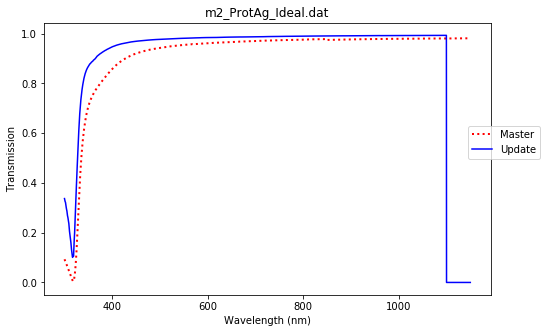

In [7]:
# Plot components with a change. 
for component in set(diff_components):
    plt.figure(figsize=(8, 5))
    m_idx = m_componentNames.index(component)
    u_idx = u_componentNames.index(component)
    m_comp = Bandpass()
    m_comp.readThroughput(masterfiles[m_idx])
    u_comp = Bandpass()
    u_comp.readThroughput(updatefiles[u_idx])
    plt.plot(m_comp.wavelen, m_comp.sb, color='red', linestyle=':', linewidth=2, label='Master')
    plt.plot(u_comp.wavelen, u_comp.sb, color='blue', linestyle='-', label='Update')
    plt.legend(loc=(0.95, 0.5), fancybox=True)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Transmission')
    plt.title('%s' % component)

In [8]:
# Now read everything and make some plots as well as compute m5 values.
# Set the default directories for the updated curves as well as the master curves. 
updateDirs = st.setDefaultDirs(rootDir=updatedir)
masterDirs = st.setDefaultDirs(rootDir=masterdir)

print(updateDirs.keys())
print("Update directories (e.g.):", updateDirs['detector'])
print("Master directories (e.g.):", masterDirs['detector'])

dict_keys(['detector', 'lens1', 'lens2', 'lens3', 'filters', 'mirror1', 'mirror2', 'mirror3', 'atmosphere'])
Update directories (e.g.): /Users/bxin/lsst_stack/syseng_throughputs/components/camera/detector/joint_minimum
Master directories (e.g.): syseng_master/components/camera/detector/joint_minimum


In [9]:
# Read the combined default components. (note this uses the joint_minimum detector)
# Hardware = telescope + camera only. System = also with atmosphere.
update_hardware, update_system = st.buildHardwareAndSystem(updateDirs)
master_hardware, master_system = st.buildHardwareAndSystem(masterDirs)

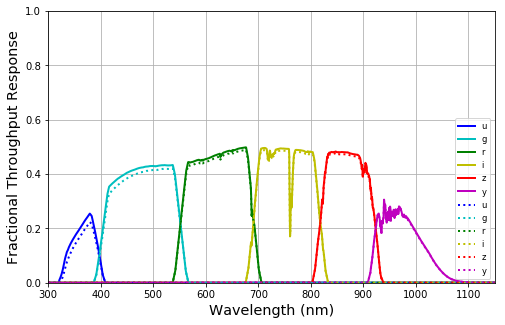

In [10]:
# Plot all of the components: everything
plt.figure(figsize=(8, 5))
st.plotBandpasses(update_system, newfig=False, addlegend=False)
st.plotBandpasses(master_system, linestyle=':', newfig=False, addlegend=True)

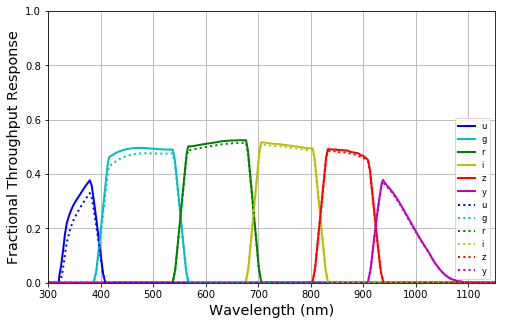

In [11]:
# Plot all of the components. Just the hardware
plt.figure(figsize=(8, 5))
st.plotBandpasses(update_hardware, newfig=False, addlegend=False)
st.plotBandpasses(master_hardware, linestyle=':', newfig=False, addlegend=True)

In [12]:
# Compare m5 values before/after the update.
update_m5 = st.makeM5(update_hardware, update_system, darksky=None, 
                      exptime=15, nexp=2, readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(6.423/2*100)**2, X=1.0)
master_m5 = st.makeM5(master_hardware, master_system, darksky=None, 
                      exptime=15, nexp=2, readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(6.423/2*100)**2, X=1.0)

In [13]:
update_m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.960730,80.840573,27.009181,0.035837,0.057997,0.522669,0.038185,23.165597,0.576230,0.362984,23.849238,550.932990,23.9,23.4
g,0.87,0.76714,22.257758,411.094794,28.399288,0.128938,0.154358,0.195371,0.038743,24.447490,0.176182,0.093056,24.840316,795.628429,25.0,24.6
r,0.83,0.73426,21.196590,818.797145,28.177407,0.105106,0.115690,0.104170,0.038990,24.467511,0.096081,0.047725,24.380855,990.243723,24.7,24.3
i,0.80,0.70960,20.477419,1173.487799,27.879556,0.079889,0.085493,0.073607,0.039101,24.363045,0.068928,0.033121,23.956774,1112.330543,24.0,23.6
z,0.78,0.69316,19.599578,1782.992383,27.481805,0.055384,0.057871,0.047694,0.039235,24.201828,0.046435,0.021447,23.384125,1306.751554,23.3,22.9
y,0.76,0.67672,18.610405,2371.023361,26.687500,0.026648,0.030944,0.162291,0.039311,23.759692,0.035324,0.015804,22.475605,1451.707778,22.1,21.7


In [14]:
master_m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,23.005144,63.161453,26.801535,0.029599,0.047205,0.506787,0.038116,22.975999,0.664225,0.430692,23.681847,530.880050,23.9,23.4
g,0.87,0.76714,22.253253,393.142077,28.347424,0.122923,0.147005,0.194250,0.038723,24.414911,0.182927,0.097007,24.805485,783.243503,25.0,24.6
r,0.83,0.73426,21.196147,801.129885,28.153344,0.102802,0.113147,0.104107,0.038981,24.453421,0.098004,0.048766,24.366544,981.388871,24.7,24.3
i,0.80,0.70960,20.477003,1155.779694,27.862640,0.078654,0.084170,0.073597,0.039095,24.353507,0.069912,0.033637,23.947028,1105.009312,24.0,23.6
z,0.78,0.69316,19.599676,1756.888043,27.465877,0.054578,0.057029,0.047706,0.039230,24.193119,0.047092,0.021779,23.375466,1298.032719,23.3,22.9
y,0.76,0.67672,18.610310,2339.099387,26.672735,0.026288,0.030525,0.162243,0.039307,23.751802,0.035789,0.016034,22.467668,1442.606425,22.1,21.7


In [15]:
print("Resulting changes in m5 (positive = fainter)")
pd.DataFrame((update_m5.m5 - master_m5.m5).values, index=update_m5.index, columns=['Delta m5'])

Resulting changes in m5 (positive = fainter)


,Delta m5
u,0.167390
g,0.034831
r,0.014311
i,0.009746
z,0.008660
y,0.007937


In [16]:
# When all done - remove the git clone.
shutil.rmtree(masterdir)